C:\Users\User
C:\Users\User\Modeling\
     temperatures      slp  wet_bulb_temperature  specific_humidity  water  \
0           12.21  1018.53                  7.76               5.39    1.0   
1            8.17  1021.23                  4.33               4.30    1.0   
2           15.68  1018.97                 10.49               6.51    1.0   
3           22.46  1014.69                 16.98              10.21    1.0   
4           23.66  1014.24                 18.68              11.74    1.0   
..            ...      ...                   ...                ...    ...   
222         27.66  1016.01                 23.90              17.03    1.0   
223         28.00  1016.53                 22.80              15.20    1.0   
224         23.86  1013.56                 20.33              13.73    1.0   
225         20.59  1020.43                 14.60               8.35    1.0   
226         15.82  1017.05                 13.00               9.05    1.0   

        GHI      WDSP  PR

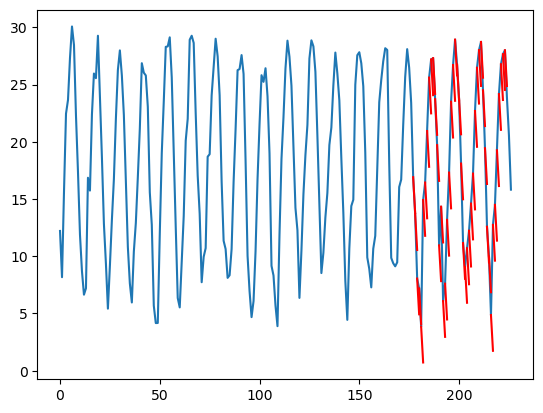

Summary:
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (1, 1, 32)                27008     
                                                                 
 lstm_5 (LSTM)               (1, 32)                   8320      
                                                                 
 dense_6 (Dense)             (1, 16)                   528       
                                                                 
 dense_7 (Dense)             (1, 8)                    136       
                                                                 
 dense_8 (Dense)             (1, 1)                    9         
                                                                 
Total params: 36,001
Trainable params: 36,001
Non-trainable params: 0
_________________________________________________________________


In [3]:
import os
import csv
import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Activation
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from math import sqrt
from matplotlib import pyplot
from numpy import array
import keras.backend as K

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)

def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    print("Number:"+str(n_vars)+" "+str(data.shape[1]))
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)

    print("Agg:")
    agg.columns = names
    print(agg)

    return agg
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# transform series into train and test sets for supervised learning
def prepare_data(data, n_test, n_lag, n_seq):

    #Prepare data for time series forecasting.
    
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    
    #Returns:
    #tuple: Training and test datasets.

    #print("Prepare data input (difference input)")
    #print(data.shape)
    #print(data)

    n_vars = 1 if type(data) is list else data.shape[1]

	# transform data to be stationary
    diff_series = difference(data, 1)
    diff_values = []
    for i in range(len(diff_series)):
        diff_values_row = []
        for j in range(len(diff_series[0])):
            diff_values_row.append(diff_series[i][j])
        diff_values.append(diff_values_row)
    #print("Diff Series:")
    #print(diff_series.shape)
    #print(diff_series)
    #print("Diff_Values:")
    #print(len(diff_values))
    #print(diff_values)
    
    # split into train and test sets
    train_values, test_values = diff_values[0:-n_test], diff_values[-n_test:]
    
    #print(train_values)
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    train_scaled_values = scaler_all_features.fit_transform(train_values)
    response_train_values = []
    for i in range(len(train_values)):
        response_train_values.append(train_values[i][0]) # Uses first column (temperatures) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)
    #response_train_values = response_train_values.reshape(-1, 1)
    #print("Response:")
    #print(response_train_values)
    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    #print("Scaled values before reshape:")
    #print(train_scaled_values.shape)
    #print(train_scaled_values)
    test_scaled_values = scaler_all_features.transform(test_values)
    
    #scaled_values = scaled_values.reshape(len(scaled_values), 1)
    scaled_values = pd.concat([pd.DataFrame(train_scaled_values), pd.DataFrame(test_scaled_values)], axis=0)
    scaled_values = np.array(scaled_values)
    
    #print("Supervised input:")
    #print(scaled_values.shape)
    #print(scaled_values)
    
    # transform into supervised learning problem X, y
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    print(type(supervised))
    supervised_values = supervised.values

    #print("Supervised going into train/test:")
    #print(len(supervised))
    #print(supervised)

    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]

    # drop rows with NaN values
    train = pd.DataFrame(train)
    train.dropna(inplace=True)
    train = np.array(train)
    
    return scaler, scaler_all_features, train, test
 
# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # design network
    model = Sequential()
    model.add(LSTM(32, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(LSTM(32))
    model.add(Dense(16, input_dim=y.shape[0], activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1))
    model.compile(loss=rmse, optimizer='adam', metrics=['accuracy', 'mae', rmse, mape, pearson])
    # fit network
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
    return model
 
# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
	# reshape input pattern to [samples, timesteps, features]
	X = X.reshape(1, 1, len(X))
	# make forecast
	forecast = model.predict(X, batch_size=n_batch)
	# convert to array
	return [x for x in forecast[0, :]]
 
# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = forecast_lstm(model, X, n_batch)
		# store the forecast
		forecasts.append(forecast)
	return forecasts
 
# invert differenced forecast
def inverse_difference(last_ob, forecast):
	# invert first forecast
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	# propagate difference forecast using inverted first value
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + inverted[i-1])
	return inverted
 
# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        print(forecast)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
 
# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))
 
# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
		pyplot.plot(xaxis, yaxis, color='red')
	# show the plot
	pyplot.show()


# Get the current working directory 
current_directory = os.getcwd() 

# Print the current working directory 
print(current_directory)

# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)

filename = path + 'Final_Monthly_Dataset.csv'

# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')


df = df.rename(columns={'Unnamed: 0' : 'indices'})

#Remove unused columns
df = df.drop(['Day', 'vapor_pressure'], axis=1)

# Round numbers in columns to reasonable precision
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)

df_trimmed = df[df['file_id']==6501]
df_trimmed = df_trimmed.drop(['Year', 'Month', 'file_id', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

print(df_trimmed)

dataset = df_trimmed.values

#print(dataset)

series = pd.Series(dataset[:, 0]) # Using first column (temperatures)

#print(series)

# configure
n_lag = 178
n_seq = 1
n_test = 47
n_epochs = 500
n_batch = 1

# prepare data
scaler, scaler_all_features, train, test = prepare_data(dataset, n_test, n_lag, n_seq)

print("Train:")
print(np.array(train).shape)
print(train)
print("Test:")
print(np.array(test).shape)
print(test)

# fit model
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs)
# make forecasts
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
# inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+2)
# evaluate forecasts
print(np.array(forecasts).shape)
print(forecasts)
evaluate_forecasts(actual, forecasts, n_lag, n_seq)
# plot forecasts
plot_forecasts(series, forecasts, n_test+2)
print("Summary:")
model.summary()

In [4]:
print(forecasts)

[[13.786713275909424], [10.546713275909424], [4.9267132759094245], [4.066713275909424], [0.7167132759094237], [11.786713275909424], [13.316713275909425], [17.816713275909425], [22.486713275909423], [24.076713275909423], [24.186713275909423], [20.606713275909424], [16.586713275909425], [7.826713275909423], [11.206713275909424], [2.956713275909424], [4.4767132759094235], [10.056713275909424], [14.186713275909423], [20.376713275909424], [23.586713275909425], [25.806713275909424], [23.626713275909424], [20.656713275909425], [14.976713275909425], [8.026713275909424], [5.936713275909424], [7.553824615478515], [9.106713275909424], [11.476713275909423], [14.096713275909423], [19.566713275909425], [23.346713275909423], [24.886713275909425], [25.606713275909424], [21.376713275909424], [16.316713275909425], [9.456713275909424], [6.856713275909424], [1.7367132759094241], [9.616713275909424], [11.366713275909424], [16.136713275909425], [21.046713275909426], [23.656713275909425], [24.536713275909424

In [5]:
print(model)